# STM Transit Delay Data Modeling

## Overview

This notebook explores tree-based regression and classification models in order to find the one that predicts the delay with the best accuracy.

## Data Description

`trip_id`: Unique identifier for the transit trip.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`stop_id`: Unique identifier of a stop.<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`stop_distance`: Distance between the previous and current stop, in meters.<br>
`stop_sequence`: Sequence of the stop, for ordering.<br>
`trip_progress`: How far along the trip is the vehicle, from 0 (first stop) to 1 (last stop).<br>
`stop_has_alert`: Indicates if there's a message about the stop being moved or cancelled.<br>
`sch_rel_Scheduled`, `sch_rel_Skipped`: States of the schedule.<br>
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair<br>
`month`, `day_of_week`, `hour`: Month, day of week and hour of the scheduled arrival time.<br>
`is_weekend`: Indicates if the day of the arrival time is on the weekend.<br>
`is_peak_hour`: Indicates of the day and hour of the arrival time is at peak hour (weekdays between 7-9am and 4-6pm).<br>
`incident_count`: Number of incidents within 500 meters of the stop.<br>
`incident_nearby`: Indicates if an incident happened within 500 meters of the stop.<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`windspeed`: Wind speed at 10 meters above ground, in km/h.<br>
`weather_Cloudy`, `weather_Drizzle`, `weather_Rain`: Indicates the weather category.<br>
`delay`: Difference between real and scheduled arrival time, in seconds.<br>
`delay_class`: Delay category, from 0 (early) to 4 (late).<br>

## Imports

In [1]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import shap
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier, XGBRegressor

In [2]:
df = pd.read_parquet('../data/preprocessed.parquet')
print(f'Number of rows: {len(df)}')

Number of rows: 1454541


## Split the data

In [3]:
# Train/Test Split (80-20) (stratified by delay_class)
df_train, df_temp = train_test_split(
  df,
  test_size=0.2,
  stratify=df['delay_class'],
  random_state=42
)

In [ ]:
# Sample for faster experimentation (10% of the full data)
df_train_sample, _ = train_test_split(
  df_train,
  train_size=0.1,
  stratify=df_train['delay_class'],
  random_state=42
)

In [5]:
# Check is class distribution is preserved
print(df['delay_class'].value_counts(normalize=True))
print(df_train_sample['delay_class'].value_counts(normalize=True))

delay_class
1    0.865496
2    0.118283
0    0.016222
Name: proportion, dtype: float64
delay_class
1    0.865489
2    0.118286
0    0.016225
Name: proportion, dtype: float64


In [6]:
# Separate features and target
feature_cols = [col for col in df.columns if col not in ['delay', 'delay_class']]

In [7]:
# Sample train set
X_train_sample = df_train_sample[feature_cols]
y_reg_train_sample = df_train_sample['delay']
y_class_train_sample = df_train_sample['delay_class']

In [8]:
# Full train set
X_train = df_train[feature_cols]
y_reg_train = df_train['delay']
y_class_train= df_train['delay_class']

In [9]:
# Validation and test set
df_val, df_test = train_test_split(
	df_temp,
  	test_size=0.5,
    stratify=df_temp['delay_class'],
  	random_state=42
)

del df_temp

X_val = df_val[feature_cols]
y_reg_val = df_val['delay']
y_class_val = df_val['delay_class']

X_test = df_test[feature_cols]
y_reg_test = df_test['delay']
y_class_test = df_test['delay_class']

Since only tree-based models are explored in this project, **scaling is not needed** because the models are not sensitive to the absolute scale or distribution of the features.

## Regression Model

### Random Forest Regressor

#### Fit Model

In [10]:
# Fit base model
rf_base = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_base.fit(X_train_sample, y_reg_train_sample)

RandomForestRegressor(n_jobs=-1, random_state=42)

#### Evaluate Model

In [11]:
# Create dataframe to track metrics
metrics_df = pd.DataFrame(columns=['model', 'params', 'MAE', 'RMSE', 'R²'])

In [12]:
def add_metrics(metrics_df:pd.DataFrame, model, y_pred:pd.Series, y_val:pd.Series, model_name:str) -> pd.DataFrame:
	mae = mean_absolute_error(y_val, y_pred)
	rmse = root_mean_squared_error(y_val, y_pred)
	r2 = r2_score(y_val, y_pred)

	metrics_df.loc[len(metrics_df)] = [model_name, model.get_params(), mae, rmse, r2]
	return metrics_df

In [13]:
# Calculate metrics
y_pred = rf_base.predict(X_val)
metrics_df = add_metrics(metrics_df, rf_base, y_pred, y_reg_val, 'rf_base')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

,model,MAE,RMSE,R²
0,rf_base,89.485229,146.431042,-0.017314


**MAE**<br>
On average, the predictions are off by 73 seconds, which is not very good.

**RMSE**<br>
The higher RMSE compared to MAE suggests that there are some significant prediction errors that influence the overall error metric.

**R²**<br>
The model explains 20% of the variance in the actual delays, which is not good, but understandable considering how noisy and random transit delays can be (weather, mechanical issues, accidents, etc.)

In [14]:
def plot_residuals(y_pred: pd.Series, y_true:pd.Series, model_name:str) -> None:
	fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

	# Predicted vs. actual values
	ax1.scatter(x=y_pred, y=y_true)
	ax1.set_title('Predicted vs. Actual values')
	ax1.set_xlabel('Predicted delay (seconds)')
	ax1.set_ylabel('Actual delay (seconds)')
	ax1.grid(True)

	# Residuals
	residuals = y_true - y_pred
	ax2.scatter(x=y_pred, y=residuals)
	ax2.set_title('Residual Plot')
	ax2.set_xlabel('Predicted Delay (seconds)')
	ax2.set_ylabel('Residuals (seconds)')
	ax2.axhline(0, linestyle='--', color='orange')
	ax2.grid(True)

	fig.suptitle('Residual Analysis', fontsize=18)
	fig.tight_layout()
	fig.savefig(f'../images/residual_analysis_{model_name}.png', bbox_inches='tight')
	plt.show()

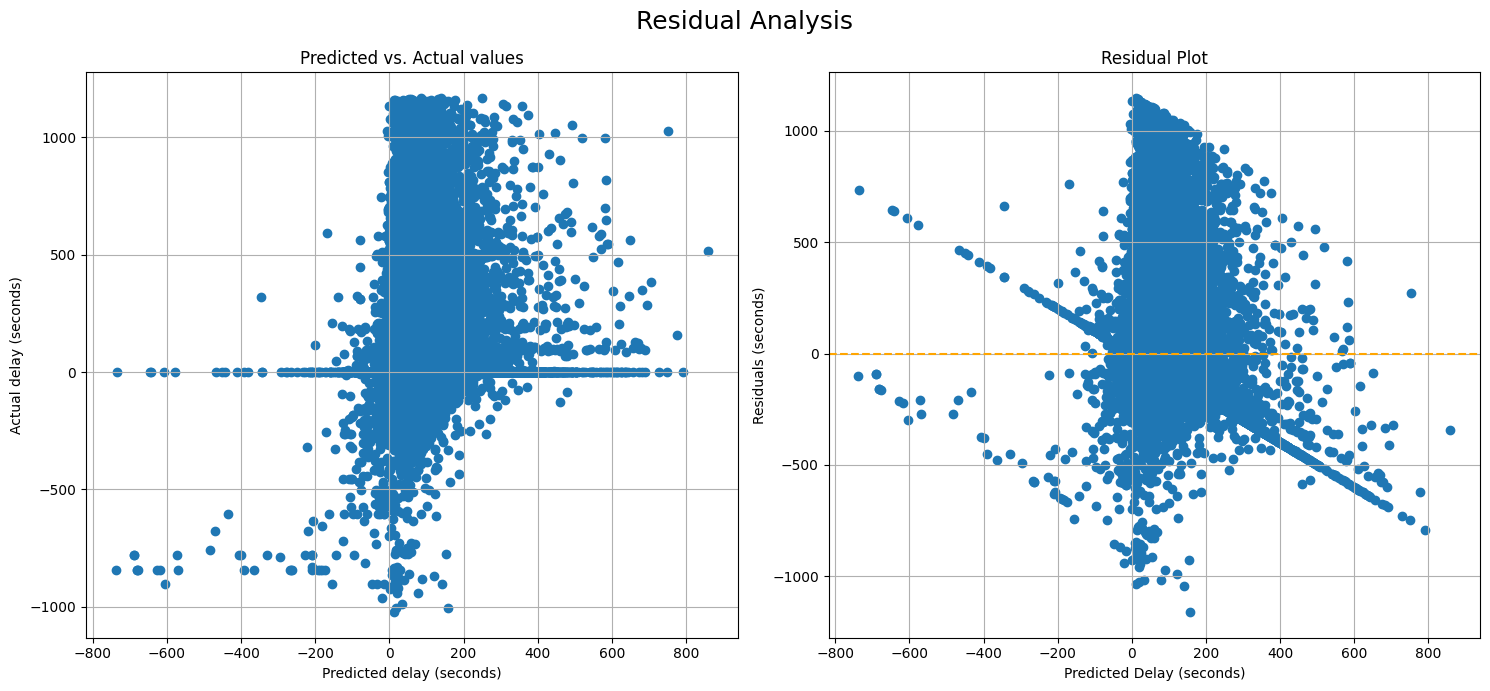

In [15]:
# Plot residual analysis
plot_residuals(y_pred, y_reg_val, 'rf_base')

The predicted vs. actual plot shows a scatter of points, with some spread around the diagonal line, which indicates the model's predictions are not perfect but are reasonable. The spread of points suggests the model has a reasonable fit but doesn't handle extreme delays very well.

From the residual plot, it seems that the residuals are fairly spread out, with visible funnel shapes and most of the data clustered around 0, but also a significant spread both above and below the 0 line. This suggests there is no clear pattern in residuals (not biased in one direction). Also, it suggests the residuals appear to increase as the predicted delay increases, meaning the model prediction errors are larger for higher predicted delays (heteroscedasticity). This means the model is better at predicting small delays than large delays.

#### Hyperparameter tuning

Due to the large volume of data, the Randomized Search will be run instead of a Grid Search.

In [16]:
# Randomized search with 3-fold CV
param_dist = {
    'n_estimators': list(range(100, 700, 100)),
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', 0.8],
    'bootstrap': [True, False],
    'max_leaf_nodes': [None, 50, 100]
}

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False),
    'R2': make_scorer(r2_score)
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=2,
    scoring=scoring,
    refit='RMSE',
    n_jobs=-1,
    random_state=42
)

random_search_rf.fit(X_train_sample, y_reg_train_sample)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 1.3min
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 1.3min
[CV] END bootstrap=False, max_depth=10, max_features=log2, max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time= 1.1min
[CV] END bootstrap=True, max_depth=10, max_features=0.8, max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time= 3.7min
[CV] END bootstrap=True, max_depth=10, max_features=0.8, max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time= 3.7min
[CV] END bootstrap=True, max_depth=10, max_features=0.8, max_leaf_nodes=None, min_samples_leaf=5, min_samples_split=10, n_estimators=300; total time

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 50],
                                        'max_features': ['sqrt', 'log2', 0.8],
                                        'max_leaf_nodes': [None, 50, 100],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600]},
                   random_state=42, refit='RMSE',
                   scoring={'MAE': make_scorer(mean_absolute_error, greater_is_better=False, response_method='predict'),
                            'R2': make_scorer(r2_score, response_method='predict'),
                            'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')},
                   verbose=2)

In [17]:
# Best model
rf_tuned = random_search_rf.best_estimator_

In [55]:
best_params = random_search_rf.best_params_

In [18]:
# Calculate metrics
y_pred = rf_tuned.predict(X_val)
metrics_df = add_metrics(metrics_df, rf_tuned, y_pred, y_reg_val, 'rf_tuned')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

,model,MAE,RMSE,R²
0,rf_base,89.485229,146.431042,-0.017314
1,rf_tuned,83.746771,142.356740,0.038510


#### Feature Importances

In [19]:
importances = rf_tuned.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_tuned.estimators_], axis=0)

In [20]:
# Sort predictors
feature_importances = pd.Series(importances, index=X_train_sample.columns)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances

stop_distance                          0.163907
stop_lon                               0.139377
stop_lat                               0.130246
vehicle_bearing                        0.086101
trip_phase_end                         0.051688
vehicle_speed                          0.047261
wind_direction                         0.038236
pressure                               0.033076
dew_point                              0.027128
stop_has_alert                         0.026777
temperature                            0.026719
relative_humidity                      0.026542
windspeed                              0.024803
wind_gusts                             0.024559
is_peak_hour                           0.023102
time_of_day_morning                    0.022193
occupancy_status                       0.020899
cloud_cover                            0.019992
trip_phase_middle                      0.013090
day_of_week                            0.012222
route_type_Day                         0

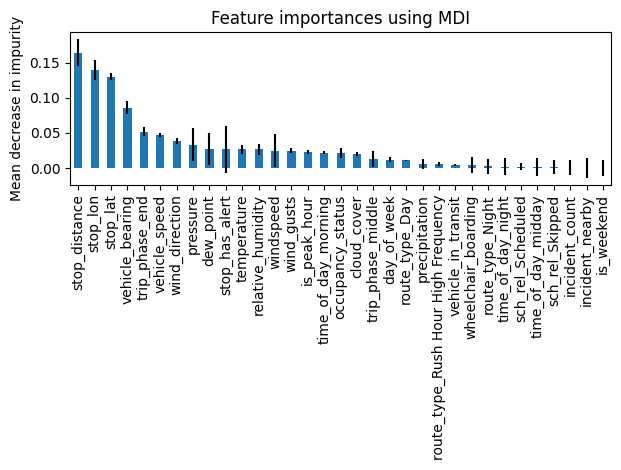

In [21]:
# Plot the impurity-based importance (MDI)
fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
plt.savefig('../images/mdi_rf_tuned.png', bbox_inches='tight')
plt.show()

**Top Features**

- `stop_distance`: Most important feature. Suggests delays are highly correlated with the distance between stops. Long gaps might lead to longer travel times or greater variability.
- `stop_lat` and `stop_lon`: Spatial location is very predictive, maybe due to geography (e.g., congestion in downtown vs. suburbs).
- `vehicle_bearing`, `vehicle_speed`: Vehicle dynamics are important. Speed and direction might indicate if a bus is ahead or behind schedule.
- `trip_phase_end`: Delays likely accumulate or reduce toward trip end.
- `wind_speed`, `wind_direction`: Severe wind can slow down a vehicle, therefore causing delays.

**Moderately Important Features**
- `dew_point`, `temperature`, `pressure`: Weather details add modest value, may affect vehicle performance or passenger behavior.
- `relative_humidity`, `visibility`, `is_peak_hour`, `occupancy_status`: Environmental and schedule-related, not dominant but still useful.

**Least Important Features**
- `time_of_day_Night`, `time_of_day_Midnight`, `is_weekend`, `sch_rel_Skipped`, `incident_count`, `incident_nearby`: Time of day, day of week and traffic incidents didn't have much impact on the delay.

#### SHAP Summary Plot

In [22]:
# SHAP can be slow with large datasets, use sample
X_val_sample = X_val[:200]

explainer = shap.TreeExplainer(rf_base, feature_perturbation='tree_path_dependent')
shap_values = explainer.shap_values(X_val_sample)

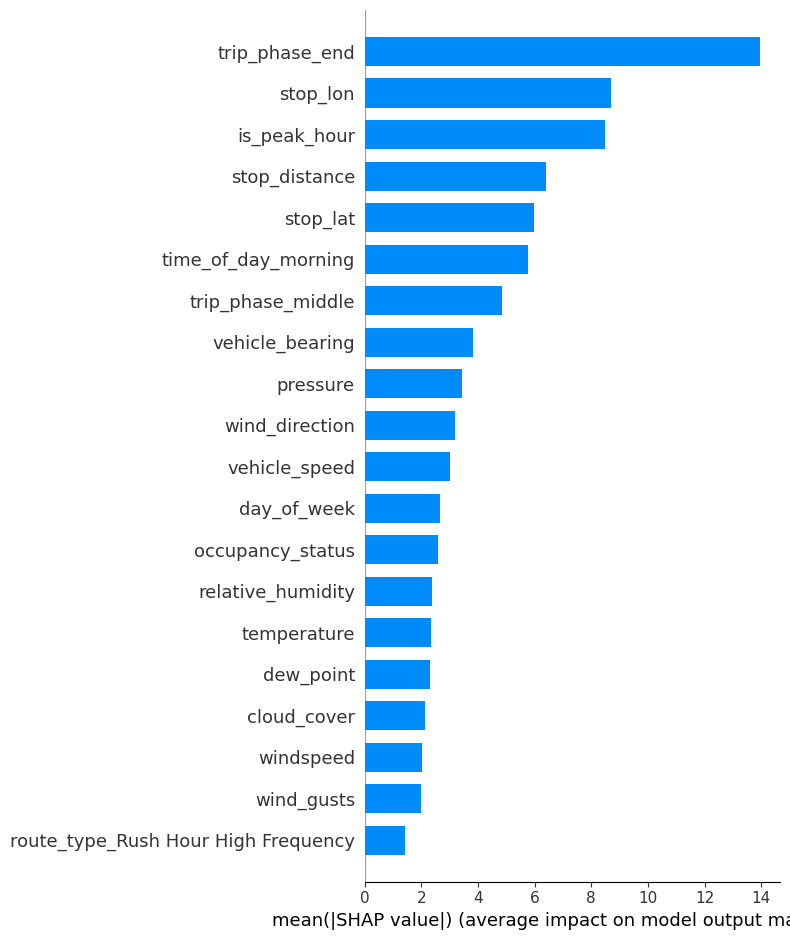

In [23]:
# Summary plot (bar chart)
shap.summary_plot(shap_values, X_val_sample, plot_type='bar')

**Global Impact**

`trip_phase_end`: Most impactful feature. End-of-trip status strongly influences delay, likely due to delay accumulation over time.<br>
`stop_lon`, `stop_lat`: Geography is highly predictive, possibly related to location-specific traffic patterns (e.g., downtown vs. suburbs).<br>
`is_peak_hour`: Vehicles are most likely to be late at rush hour.<br>
`stop_distance`: Longer gaps between stops relate to more variable delays.<br>
`time_of_day_morning`: Morning peaks influence delays significantly.<br>
`route_type_Rush Hour High Frequency`: Custom route grouping shows small but nonzero impact, useful for route-level behavioral patterns.<br>
`wind_gusts`, `cloud_cover`, `dew_point`: Contribute minimally on average.

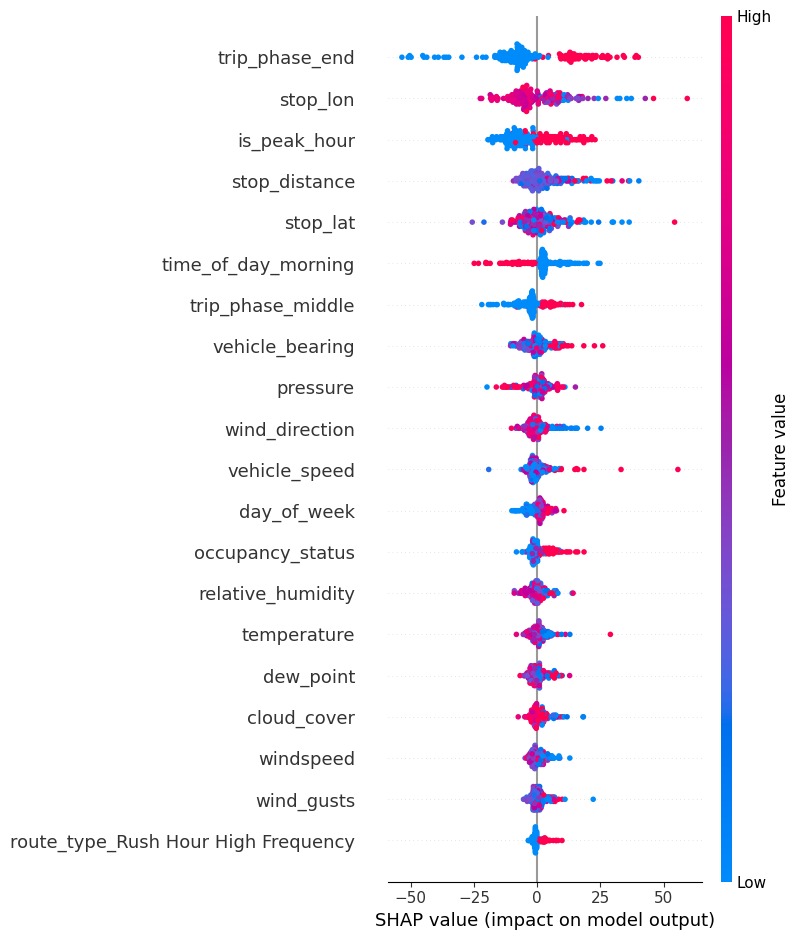

In [28]:
# Summary plot (beeswarm: shows direction and spread)
shap.summary_plot(shap_values, X_val_sample)

**Local + Global Insight**

- `trip_phase_end`: High values (red) → large positive SHAP → End-of-trip increases predicted delay.
- `stop_lon`: Certain longitudes (red or blue) drive delay up or down, likely tied to location-specific bottlenecks.
- `is_peak_hour`: Being true (red) increases predicted delay, which is expected.
- `stop_distance`: High distances (red) contribute positively to delay.
- `time_of_day_morning`: Morning time (red) increases predicted delay, as expected.
- Weather features (`pressure`, `wind_direction`, etc): Impacts are subtle, but red/blue coloring shows some directional effect (e.g., low pressure or strong wind may add small delay).
- `route_type_Rush Hour High Frequency`: Mostly clustered near zero, which indicates low or inconsistent predictive power.

In [25]:
# Force Plot (local explanation for one prediction)
sample_idx = 0
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[sample_idx], X_val_sample.iloc[sample_idx])

#### Feature Reduction Elimination Based on SHAP Plots

The goal is to remove one-hot features that have low average SHAP values, are clustered near zero in the beeswarm plot or don't show clear directional patterns.

In [30]:
shap_values

array([[  0.4620077 ,  -1.13435182,  -0.47565451, ...,   0.36916676,
         -1.15350461,   4.12922882],
       [  0.28859482,  -0.28392594,   1.7633591 , ...,  -0.20097825,
         -1.87885722,  -1.45971006],
       [ -1.42458186,   1.45253864,  -0.09442092, ...,  -0.25937556,
          6.72347246,   0.30901415],
       ...,
       [  2.05681551,  -0.46670361,  -0.67055308, ...,  -0.73800055,
          2.57905647,   1.76102134],
       [ -1.44848899,  -0.05176293,  -0.111477  , ...,   0.15240837,
          5.16982409,  -1.96039559],
       [ -9.40601164,  18.49430493,  -0.74124908, ...,  -3.7803703 ,
        -10.17554105,  -3.39861571]], shape=(200, 33))

In [31]:
# Calculate mean SHAP per feature
shap_abs_mean = np.abs(shap_values).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': X_val_sample.columns,
    'mean_abs_shap': shap_abs_mean
}).sort_values('mean_abs_shap', ascending=True)

In [32]:
shap_df

,feature,mean_abs_shap
23,incident_nearby,0.046873
20,is_weekend,0.064337
22,incident_count,0.069589
14,sch_rel_Scheduled,0.129295
15,sch_rel_Skipped,0.133386
17,time_of_day_midday,0.284095
5,route_type_Night,0.284810
19,time_of_day_night,0.499142
27,precipitation,0.767593
13,wheelchair_boarding,1.022527


In [33]:
# Display features with low SHAP score
threshold = 1.0
ohe_candidates = [col for col in X_test.columns if "_" in col and df[col].nunique() <= 2]
low_shap_ohe = shap_df[shap_df['feature'].isin(ohe_candidates) & (shap_df['mean_abs_shap'] < threshold)]
print("\n🧹 One-hot features with low SHAP impact to remove:")
print(low_shap_ohe)


🧹 One-hot features with low SHAP impact to remove:
               feature  mean_abs_shap
23     incident_nearby       0.046873
20          is_weekend       0.064337
14   sch_rel_Scheduled       0.129295
15     sch_rel_Skipped       0.133386
17  time_of_day_midday       0.284095
5     route_type_Night       0.284810
19   time_of_day_night       0.499142


In [52]:
best_features = list(set(feature_cols).difference(set(low_shap_ohe['feature'].to_list())))

In [54]:
# Keep best features
X_train_best = X_train[best_features]
X_train_sample_best = X_train[best_features]
X_val_best = X_val[best_features]
X_test_best = X_test[best_features]

In [57]:
best_params

{'n_estimators': 300,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_leaf_nodes': None,
 'max_features': 0.8,
 'max_depth': 10,
 'bootstrap': True}

In [ ]:
# Retrain model on reduced features
rf_retrained = RandomForestRegressor(
  	n_estimators=best_params['n_estimators'],
  	min_samples_split=best_params['min_samples_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	max_depth=best_params['max_depth'],
  	max_features=best_params['max_features'],
    bootstrap=best_params['bootstrap'],
  	random_state=42,
    n_jobs=-1
)

rf_retrained.fit(X_train_sample_best, y_reg_train_sample)

In [ ]:
# Evaluate model
y_pred = rf_retrained.predict(X_val_best)

metrics_df = add_metrics(metrics_df, rf_retrained, y_pred, y_reg_val, 'rf_retrained')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

#### Retune Parameters

In [ ]:
# Randomized search

#### Revalidate Model

In [ ]:
# Evaluate model
y_pred = rf_final.predict(X_val_best)

metrics_df = add_metrics(metrics_df, rf_final, y_pred, y_val, 'rf_final')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

Interpret results

In [ ]:
plot_residuals(y_pred, y_val, 'rf_final')

The plots didn't change much.

Interpret plot

In [ ]:
# Display best model
metrics_df.loc[metrics_df['RMSE'].idxmin(), ['model', 'MAE', 'RMSE', 'R²']]

In [ ]:
rf_final = rf_retrained

In [ ]:
# Save best parameters and features
rf_attributes = {
	'best_params': best_params,
  	'best_features': best_features,
}

with open('../models/rf_attributes.pkl', 'wb') as handle:
	pickle.dump(rf_attributes, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Save model
joblib.dump(rf_final, '../models/rf_model.pkl')

### XGBoost Regressor

#### Fit Base Model

In [ ]:
# Initialize the XGBoost model with default parameters
xg_base = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

In [ ]:
# Train a model
xg_base.fit(X_train, y_train)

#### Evaluate model

In [ ]:
y_pred = xg_base.predict(X_val)

metrics_df = add_metrics(metrics_df, xg_base, y_pred, y_val, 'xg_base')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

**MAE:**

This is a significant improvement over the previous models. The model is now, on average, 65.8 seconds off in its predictions, which is a reduction from the previous 69.6 seconds with the Random Forest and Gradient Boosting models.

**RMSE:**

The RMSE has also decreased compared to the previous ensemble model (117.83), indicating that the XGBoost model is performing better and has reduced the impact of large errors.

**R²:**

This is a substantial improvement from 0.247 (with the ensemble model). With an R-squared of 0,318%, the XGBoost model explains more variance in the data, which shows that it's capturing more of the underlying patterns than the previous models.

**Interpretation**

XGBoost is performing better than the previous models (Random Forest and Gradient Boosting ensemble), particularly in terms of MAE and RMSE. The higher R-squared value also suggests that the model is now explaining more of the variance in the target variable.

#### Hyperparameter tuning

In [ ]:
# Create a GridSearchCV object
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(
				estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
				param_grid=param_grid,
				cv=3,
				verbose=1,
				n_jobs=-1)

# Fit the model
grid_search.fit(X_train, y_train)

In [ ]:
# Best parameters found
print(f'Best parameters: {grid_search.best_params_}')

In [ ]:
# Use the best model
xg_tuned = grid_search.best_estimator_

In [ ]:
# Evaluate the best model
y_pred = xg_tuned.predict(X_val)

metrics_df = add_metrics(metrics_df, xg_tuned, y_pred, y_val, 'xg_tuned')
metrics_df[['model', 'MAE', 'RMSE', 'R²']]

**MAE:**

This is a small improvement over the previous MAE of 65.77 seconds. The model is now, on average, 64.2 seconds off in its predictions, which is a good step forward.

**RMSE:**

The RMSE has decreased again, from 112.11 to 110.89 seconds, indicating that the model has become slightly more accurate, especially in handling larger errors.

**R²:**

The R-squared value has increased marginally from 0.318 to 0.322, suggesting that the model is now explaining a bit more of the variance in the data, which is an improvement.

## Classification Model

## Final Model

### Evaluation

### Make Prediction

## End